In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') 
%cd "/content/gdrive/My Drive/Econ488Paper" 

Mounted at /content/gdrive
/content/gdrive/My Drive/Econ488Paper


In [ ]:
import cvxpy as cp 
import pandas as pd
import numpy as np  
from datetime import datetime
from matplotlib.dates import date2num 
import matplotlib.pyplot as plt  
from matplotlib import pyplot as plt, rcParams 

# rcParams['figure.dpi'] = 110
# rcParams['figure.figsize'] = (7, 5)  

import warnings
warnings.filterwarnings("ignore") 

In [ ]:
def closest_in_cases(data, county_name = "Meade South Dakota", num_neighbors = 10): 
    """
    CLOSEST IN CASES

        Finds the counties the best match the number of cases over time to a given county 
                 Passing in county_name = "Meade", k_neighbors = 10 returns a dataframe with the 10 counties in 
                 South Dakota that best match the case counts of Meade County 

        accepts: data: a dataframe of cases for a specific state 
                 (you can put in a dataframe you get from the state_cases function above) 
                 county_name: the name of a county that we need neighbors for

        returns: New dataframe with the cases for counties that 
                 match trends of county_name parameter 
    """
    # get sounty-specific obs.  
    county = data[county_name]   
    norms = np.linalg.norm(data.values.T - county.values, axis = 1) 
    # rank closest counties in terms of cases based on 2-norm         
    neighbor_indices = np.argsort(norms)[: num_neighbors + 1]    
    return data.iloc[:, neighbor_indices]     

In [ ]:
class synthetic_control: 
    """
    Synthetic Control Class for generating counterfactual when an observable control is not available

    Parameters: 
        data: pandas dataframe with county-level daily covid cases around US counties
        county_name: name of a specific county that we wish to study (the "treated county")

    Generates synthetic control by matching "treated" county (county_name) with otherr counties around US based on pre-rally 
    observable characteristics. The synthetic control is taken as the weighted averrage of these counties. 
    We find the weights for the weighted average by minimizing RMSE subject to SUM(weights) = 1, and w_i >=0 for all i. 
    We also implement L1 regularization to penalize overfitting. 

    """

    def __init__(self, data, county = "Meade South Dakota"):   
        self.data = data 
        self.treatment_county = county 
        
    def selected_subsets(self, state_counties, county = "Meade South Dakota", k_neighbors = 21, start_date = "2020-07-10", 
                                                                               treatment_date = "2020-08-06",  
                                                                               end_date = "2020-09-02"):    
        """
        Partition data into pre-event and post-event subsets based on user-specified 
        dates and number of neighbor counties that match on case numbers pre-event

        Parameters: 
            state_counties: data containing covid-cases per county per state over time
            county: "treated" county in question 
            k_neighbors: number of counties to match on, used in closest_in_classes method (donor counties) 
            start_date: first date in pre-period 
            treatment_date: last day in pre-period, first day in post-period 
            end_date: last day in post-period 
        """
        pre_period = state_counties[(start_date <= state_counties.index) & (state_counties.index <= treatment_date)]  
        counties_subset = closest_in_cases(pre_period, county_name = county, num_neighbors = k_neighbors).columns 
        subset = state_counties.loc[:, counties_subset]  

        # define pre/post treatment periods  
        full_period = subset[(start_date <= subset.index) & (subset.index <= end_date)]    
        pre_period = subset[(start_date <= subset.index) & (subset.index <= treatment_date)] 

        # isolate pre-treatment period data 
        y_pre_period = pre_period[county]
        X_pre_period = pre_period.drop([county], axis = 1)

        # isolate full time period data 
        y_full_period = full_period[county] 
        X_full_period = full_period.drop([county], axis = 1) 

        # return the 4 specified time periods 
        return X_pre_period, y_pre_period, X_full_period, y_full_period 


    def generate_synthetic_control(self, county = "Meade South Dakota", k_neighbors = 21, start_date = "2020-07-10", 
                                                  treatment_date = "2020-08-06",  
                                                  end_date = "2020-09-02"): 
        """
        Generates synthetic control through L1-regulated convex optimization problem
        to minimize RMSE subject to SUM(weights) = 1, and w_i >=0 for all i. 

        Parameters: 
            county: "treated" county in question 
            k_neighbors: number of counties to match on, used in closest_in_classes method (donor counties) 
            start_date: first date in pre-period 
            treatment_date: last day in pre-period, first day in post-period 
            end_date: last day in post-period 
        """
        # partition data 
        X_pre_period, y_pre_period, X_full_period, y_full_period = self.selected_subsets(self.data, 
                                                                                         county = county, 
                                                                                         k_neighbors = k_neighbors, 
                                                                                         start_date = start_date,
                                                                                         treatment_date = treatment_date,  
                                                                                         end_date = end_date)  

        def loss_fn(X, Y, beta):
            # RMSE loss 
            return cp.norm2(X @ beta - Y)**2

        def regularizer(beta):
            # L1 regularization 
            return cp.norm1(beta) 

        def objective_fn(X, Y, beta, lambd):
            return loss_fn(X, Y, beta) + lambd * regularizer(beta)

        def mse(X, Y, beta):
            return (1.0 / X.shape[0]) * loss_fn(X, Y, beta).value

        m, n = X_pre_period.shape 
        date_index = X_full_period.index  

        X_full_copy = X_full_period.copy() 
        temp_list = X_full_period.columns.tolist() 
        self.donor_counties = temp_list 

        X_pre_period = X_pre_period.values 
        y_pre_period = y_pre_period.values 
        X_full_period = X_full_period.values 
        y_full_period = y_full_period.values

        # init optimization vars for CVXPY 
        beta = cp.Variable(n)
        constraint = [beta >= 0, sum(beta) == 1]  
        lambd = cp.Parameter(nonneg = True) 
        objective = cp.Minimize(objective_fn(X_pre_period, y_pre_period, beta, lambd))  
        problem = cp.Problem(objective, constraint)

        lambd_values = np.logspace(-2, 3, 50)
        train_errors = []
        beta_values = [] 
         
        # cross-validate for different lambda params in L1 regularization 
        for v in lambd_values:
            lambd.value = v
            problem.solve()
            train_errors.append(mse(X_pre_period, y_pre_period, beta))  
            beta_values.append(beta.value) 

        weights = beta_values[np.argmin(train_errors)] 
        weights = [0 if  np.allclose(weight, 0.0) else weight for weight in weights] 

        # get synthetic control 
        synth_control = np.dot(X_full_period, weights) 
        array_vals = np.array([y_full_period, synth_control, y_full_period - synth_control]).T  

        df = pd.DataFrame(array_vals).set_index(date_index) 
        df.columns = [self.treatment_county + " " + "True Cases", self.treatment_county + " " + "Synthetic", 
                                                                  self.treatment_county + " " + "Difference"]    

        if county == "Meade South Dakota": 
            print("WEIGHTS ALL > 0: {}".format(all(np.array(weights) >= 0)))  
            print("SUM OF WEIGHTS = {:.4f}".format(sum(weights))) 
            self.weights = np.array(weights) 
            self.X_pre = X_pre_period
            self.X_full = X_full_period
            self.y_pre = y_pre_period
            self.y_full = y_full_period 
            self.synthetic_df = df  
    
        else: 
            try: 
                self.donor_counties.remove(self.treatment_county) 
            except: 
                pass  
            return df 


    def generate_placebos(self, ):  
        """
        helper function to generate synthetic controls for all counties in donor pool 
        to comopare magnitude of effects of rally in those counties too 
        """
        self.data = self.data.drop([self.treatment_county], axis = 1) 

        county_1 = self.donor_counties[0] 

        placebo_df = self.generate_synthetic_control(county = county_1).iloc[:, -1] 

        for county in self.donor_counties[1: ]: 

            placebo_synth = self.generate_synthetic_control(county = county) 

            placebo_df = pd.concat([placebo_df, placebo_synth.iloc[:, -1]], axis = 1)  

        placebo_df.columns = self.donor_counties
        self.placebos = placebo_df   


In [ ]:
def plotting(df, placebos): 

    plt.figure(figsize = (11, 5))

    plt.subplot(121) 
    plt.plot(df.iloc[:, 0].values, "r", label = "True Cases") 
    plt.plot(df.iloc[:, 1].values, "k--", label = "Synthetic Meade County") 
    plt.vlines(x = 24, ymin = 20, ymax = 325) 
    plt.vlines(x = 28, ymin = 20, ymax = 325)  
    plt.vlines(x = 37, ymin = 20, ymax = 325) 
    plt.xticks(range(len(df.iloc[:, 0].values)), df.index, rotation = "vertical")
    plt.title("Synthetic Control for Meade County") 
    plt.ylabel("Total Total Cases") 
    plt.xlabel("Date")
    plt.ylim((35, 325)) 
    plt.legend() 
    plt.grid()        
    plt.tight_layout() 

    plt.subplot(122) 
    for i in range(placebos.shape[1]):  
        plt.plot(placebos.values[:, i], "gray")
    plt.plot(df.iloc[:, -1].values, "k", label = "Treated County") 
    plt.xticks(range(len(df.iloc[:, 0].values)), df.index, rotation = "vertical") 
    plt.title("Placebo Tests")   
    plt.ylabel("Difference Between True Cases and Estimates") 
    plt.vlines(x = 28, ymin = -100, ymax = 200)  
    plt.ylim((-100, 200))
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

In [ ]:
############# READ IN DATA ######################

In [ ]:
data = pd.read_csv("./final_data/final_cases.csv", index_col = 0)       
mask_data = pd.read_csv("./final_data/county_demographics_final.csv", index_col = 0)    
 
dates = data.date 
counties = data.county.unique().tolist()  
temp_cases = data.cases.values.reshape(len(counties), 55).T    

fips = mask_data.fips.tolist()    

In [ ]:
len(fips)

2971

In [ ]:
data.head()

,date,county,fips,cases,time_index,county_num,treatment_indicator,x_cases
0,2020-07-10,Abbeville South Carolina,45001,141,1,1,0,141
1,2020-07-11,Abbeville South Carolina,45001,150,2,1,0,150
2,2020-07-12,Abbeville South Carolina,45001,153,3,1,0,153
3,2020-07-13,Abbeville South Carolina,45001,157,4,1,0,157
4,2020-07-14,Abbeville South Carolina,45001,162,5,1,0,162


# SYNTH FOR MEADE WITH WHOLE US 

#### MATCHING ON CASES ALONE

In [ ]:
final_df = pd.DataFrame(temp_cases, columns = counties).set_index(data.date.values[: 55]) 

In [ ]:
synth = synthetic_control(final_df, "Meade South Dakota")  
synth.generate_synthetic_control(k_neighbors = 21) 
df = synth.synthetic_df 
synth.generate_placebos() 

WEIGHTS ALL > 0: True
SUM OF WEIGHTS = 1.0000


In [ ]:
len(synth.donor_counties) 

21

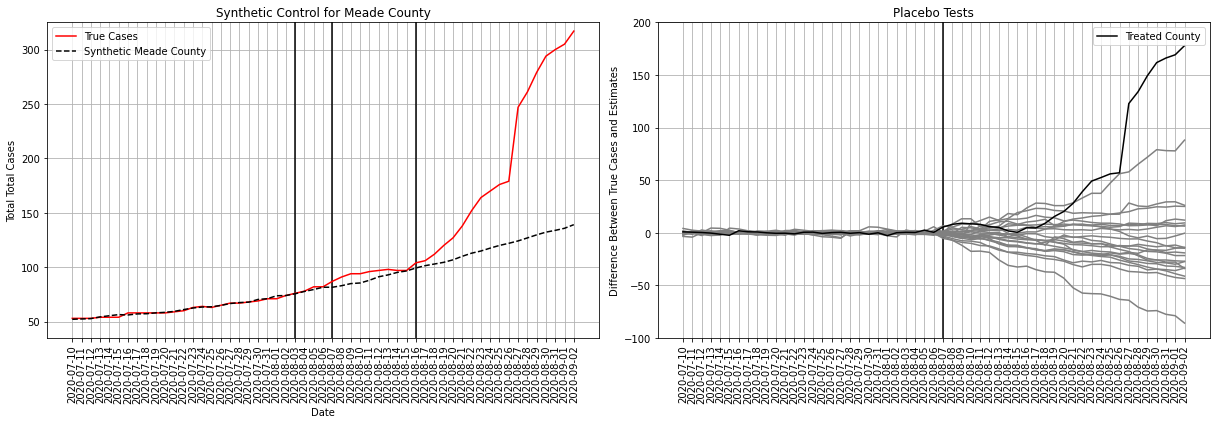

In [ ]:
plt.figure(figsize = (17, 6))
# plotting(df, synth.placebos)
plt.subplot(121) 
plt.plot(df.iloc[:, 0].values, "r", label = "True Cases") 
plt.plot(df.iloc[:, 1].values, "k--", label = "Synthetic Meade County") 
plt.vlines(x = 24, ymin = 20, ymax = 325) 
plt.vlines(x = 28, ymin = 20, ymax = 325)  
plt.vlines(x = 37, ymin = 20, ymax = 325) 
plt.xticks(range(len(df.iloc[:, 0].values)), df.index, rotation = "vertical")
plt.title("Synthetic Control for Meade County") 
plt.ylabel("Total Total Cases") 
plt.xlabel("Date")
plt.ylim((35, 325)) 
plt.legend() 
plt.grid()        
 

plt.subplot(122) 
for i in range(synth.placebos.shape[1]):  
    plt.plot(synth.placebos.values[:, i], "gray")
plt.plot(df.iloc[:, -1].values, "k", label = "Treated County") 
plt.xticks(range(len(df.iloc[:, 0].values)), df.index, rotation = "vertical") 
plt.title("Placebo Tests")   
plt.ylabel("Difference Between True Cases and Estimates") 
plt.vlines(x = 28, ymin = -100, ymax = 200)  
plt.ylim((-100, 200))
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
np.mean(synth.y_pre), np.mean(np.mean(synth.X_pre, axis = 0)), df[df.index <= "2020-08-06"].iloc[:, 1].mean()

(63.92857142857143, 63.95068027210885, 63.96053016569993)

## MATCHING ON MASK DATA AND CASES 

In [ ]:
fips = mask_data.fips.tolist()    
fips_subset = fips[: 151]   
temp = data[data.fips.isin(set(fips_subset))]  
dates = temp.date 
counties = temp.county.unique().tolist()  
temp_cases = temp.cases.values.reshape(len(counties), 55).T  

new_df = pd.DataFrame(temp_cases, columns = counties).set_index(dates.values[: 55])    

In [ ]:
# mask_data[mask_data.fips.isin(set(fips_subset))].mean() 

In [ ]:
# mask_data[mask_data.fips == 46093]

In [ ]:
synth = synthetic_control(new_df, "Meade South Dakota")  
synth.generate_synthetic_control(k_neighbors = 21) 
df = synth.synthetic_df 
synth.generate_placebos() 

WEIGHTS ALL > 0: True
SUM OF WEIGHTS = 1.0000


In [ ]:
# df.tail()

In [ ]:
# len(synth.donor_counties), len(synth.weights)

In [ ]:
# w = pd.DataFrame({"Donor Counties": synth.donor_counties, "Weights": synth.weights})
# w

In [ ]:
# n = w.values 
# np.hstack(n[: 11], 

In [ ]:
"""
n = pd.DataFrame({"Donor Counties": synth.donor_counties, "Weights": synth.weights}).values 
l = pd.DataFrame({"County": n[:, 0][: 11], "Weight": n[:, 1][: 11]})
r = pd.DataFrame({"County2": n[:, 0][11: ], "Weight2": n[:, 1][11: ]}).append(pd.DataFrame({"County2": [0], "Weight2": [0]}))
r.index = list(range(0, 11))
pd.concat([l, r], axis = 1).to_latex(index = True, multirow = False, float_format="{:.3f}".format) 
"""

'\nn = pd.DataFrame({"Donor Counties": synth.donor_counties, "Weights": synth.weights}).values \nl = pd.DataFrame({"County": n[:, 0][: 11], "Weight": n[:, 1][: 11]})\nr = pd.DataFrame({"County2": n[:, 0][11: ], "Weight2": n[:, 1][11: ]}).append(pd.DataFrame({"County2": [0], "Weight2": [0]}))\nr.index = list(range(0, 11))\npd.concat([l, r], axis = 1).to_latex(index = True, multirow = False, float_format="{:.3f}".format) \n'

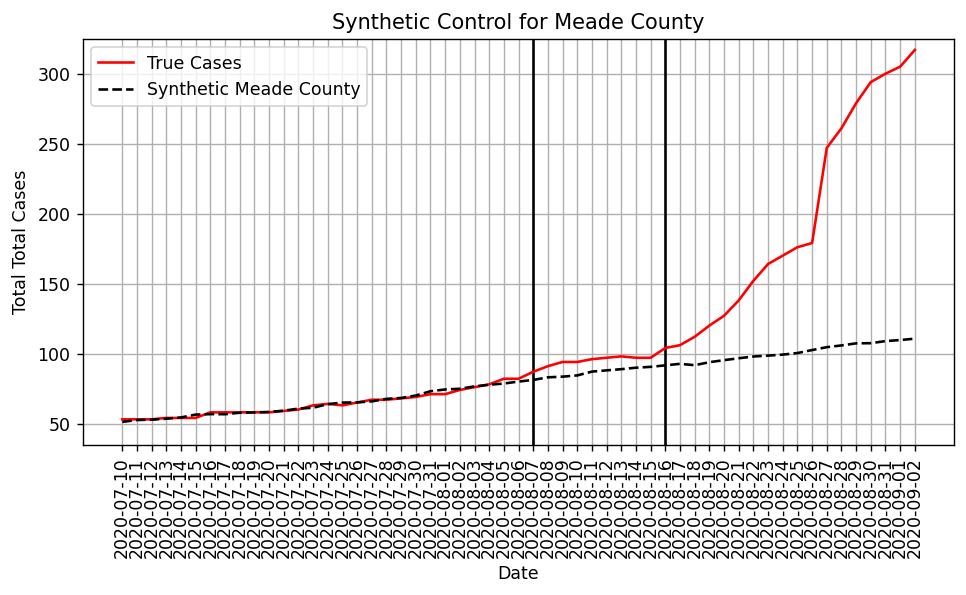

In [ ]:
# plotting(df, synth.placebos) 
# plt.figure(figsize = (17, 6))
plt.figure(figsize = (9, 4.3), dpi = 125)
# plotting(df, synth.placebos)
# plt.subplot(121) 
plt.plot(df.iloc[:, 0].values, "r", label = "True Cases") 
plt.plot(df.iloc[:, 1].values, "k--", label = "Synthetic Meade County") 
# plt.vlines(x = 24, ymin = 20, ymax = 325) 
plt.vlines(x = 28, ymin = 20, ymax = 325)  
plt.vlines(x = 37, ymin = 20, ymax = 325) 
plt.xticks(range(len(df.iloc[:, 0].values)), df.index, rotation = "vertical")
plt.title("Synthetic Control for Meade County") 
plt.ylabel("Total Total Cases") 
plt.xlabel("Date")
plt.ylim((35, 325)) 
plt.legend() 
plt.grid()        
 
"""
plt.subplot(122) 
for i in range(synth.placebos.shape[1]):  
    plt.plot(synth.placebos.values[:, i], "gray") 
plt.plot(df.iloc[:, -1].values, "k", label = "Treated County") 
plt.xticks(range(len(df.iloc[:, 0].values)), df.index, rotation = "vertical") 
plt.title("Placebo Tests")   
plt.xlabel("Date")
plt.ylabel("Difference Between True Cases and Estimates") 
plt.vlines(x = 28, ymin = -100, ymax = 200)  
plt.ylim((-100, 200))
plt.legend()
plt.grid()

plt.tight_layout()

"""
plt.show()

In [ ]:
np.mean(synth.y_pre), df[df.index <= "2020-08-06"].iloc[:, 1].mean(), np.mean(np.mean(synth.X_pre, axis = 0))

(63.92857142857143, 63.92520163291142, 63.24659863945579)

In [ ]:
donor_ave = mask_data[mask_data.fips.isin(set(fips_subset))].iloc[:, 2: -1].mean() 
meade_vals = mask_data[mask_data.fips == 46093].values[0][2: -1]  

In [ ]:
df = pd.DataFrame({"Meade County": meade_vals, "Donor Average": donor_ave, "Synthetic": np.zeros_like(donor_ave)})   
df

,Meade County,Donor Average,Synthetic
never,0.123,0.103669,0.0
rarely,0.078,0.085828,0.0
sometimes,0.161,0.143371,0.0
frequently,0.214,0.213258,0.0
always,0.425,0.453914,0.0
pct_white,0.905125,0.859739,0.0
pct_black,0.0198009,0.092407,0.0
pct_american_indian,0.0316603,0.017758,0.0
pct_asian,0.0103064,0.010083,0.0
pct_pacific_island,0.00091769,0.000758,0.0


In [ ]:
df.index = ["Never", "Rarely", "Sometimes", "Frequently", "Always", "% White", "% Black", "% American Indian", "% Asian", "% Pacific Island", "% Pop. Age 18-19"] 
df

,Meade County,Donor Average,Synthetic
Never,0.123,0.103669,0.0
Rarely,0.078,0.085828,0.0
Sometimes,0.161,0.143371,0.0
Frequently,0.214,0.213258,0.0
Always,0.425,0.453914,0.0
% White,0.905125,0.859739,0.0
% Black,0.0198009,0.092407,0.0
% American Indian,0.0316603,0.017758,0.0
% Asian,0.0103064,0.010083,0.0
% Pacific Island,0.00091769,0.000758,0.0


In [ ]:
df.to_latex(index = True, multirow = False, float_format="{:.3f}".format) 

'\\begin{tabular}{llrr}\n\\toprule\n{} & Meade County &  Donor Average &  Synthetic \\\\\n\\midrule\nNever             &        0.123 &          0.104 &      0.000 \\\\\nRarely            &        0.078 &          0.086 &      0.000 \\\\\nSometimes         &        0.161 &          0.143 &      0.000 \\\\\nFrequently        &        0.214 &          0.213 &      0.000 \\\\\nAlways            &        0.425 &          0.454 &      0.000 \\\\\n\\% White           &        0.905 &          0.860 &      0.000 \\\\\n\\% Black           &        0.020 &          0.092 &      0.000 \\\\\n\\% American Indian &        0.032 &          0.018 &      0.000 \\\\\n\\% Asian           &        0.010 &          0.010 &      0.000 \\\\\n\\% Pacific Island  &        0.001 &          0.001 &      0.000 \\\\\n\\% Pop. Age 18-19  &        0.152 &          0.148 &      0.000 \\\\\n\\bottomrule\n\\end{tabular}\n'

# SYNTH FOR COUNTIES NOT IN SD OR BORDER STATES 

##### HAVE NOT YET MATCHED ON FULL COUNTY LEVEL DATA

In [ ]:
temp = data[~data.county.str.contains("South Dakota")]
temp = temp[~temp.county.str.contains("North Dakota")] 
temp = temp[~temp.county.str.contains("Nebraska")]
temp = temp[~temp.county.str.contains("Minnesota")]
temp = temp[~temp.county.str.contains("Wyoming")]
temp = temp[~temp.county.str.contains("Montana")] 
temp = temp[~temp.county.str.contains("Iowa")]  
 
no_borders = temp.copy() 
temp.shape

(138545, 8)

In [ ]:
meade = data[data.county == "Meade South Dakota"] 

temp = temp.append(meade) 
no_borders = no_borders.append(meade)

In [ ]:
dates = temp.date 
counties = temp.county.unique().tolist()   
temp_cases = temp.cases.values.reshape(len(counties), 55).T 
final_df_no_borders = pd.DataFrame(temp_cases, columns = counties).set_index(dates.values[: 55])   

In [ ]:
synth = synthetic_control(final_df_no_borders, "Meade South Dakota") 
synth.generate_synthetic_control(k_neighbors = 21) 
df = synth.synthetic_df 
synth.generate_placebos()  

WEIGHTS ALL > 0: True
SUM OF WEIGHTS = 1.0000


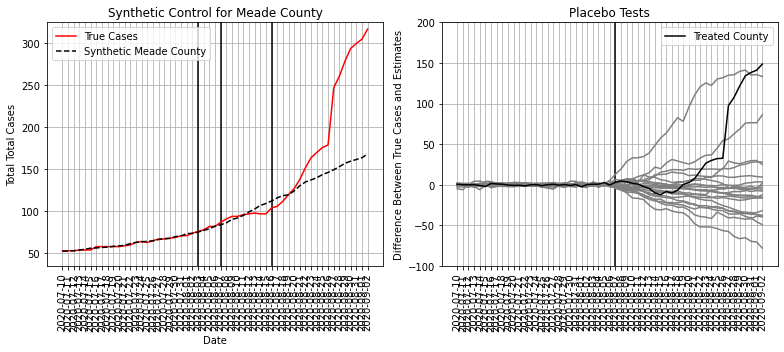

In [ ]:
plotting(df, synth.placebos)

In [ ]:
np.mean(synth.y_pre), np.mean(np.mean(synth.X_pre, axis = 0)), df[df.index <= "2020-08-06"].iloc[:, 1].mean()   

(63.92857142857143, 64.3044217687075, 64.00757031872935)

## MATCHING ON CASES + MASK DATA 

In [ ]:
temp.head()

,date,county,fips,cases,time_index,county_num,treatment_indicator,x_cases
0,2020-07-10,Abbeville South Carolina,45001,141,1,1,0,141
1,2020-07-11,Abbeville South Carolina,45001,150,2,1,0,150
2,2020-07-12,Abbeville South Carolina,45001,153,3,1,0,153
3,2020-07-13,Abbeville South Carolina,45001,157,4,1,0,157
4,2020-07-14,Abbeville South Carolina,45001,162,5,1,0,162


In [ ]:
fips_subset = set(fips[: 201])      
temp = no_borders[no_borders.fips.isin(fips_subset)] 

dates = temp.date   
counties = temp.county.unique().tolist()   
temp_cases = temp.cases.values.reshape(len(counties), 55).T 

new_df_no_borders = pd.DataFrame(temp_cases, columns = counties).set_index(dates.values[: 55])   

In [ ]:

###### MAKE SURE YOU ARE DOING THIS MASK MEANS RIGHT #####

In [ ]:
# mask_data[mask_data.COUNTYFP.isin(set(fips_subset))].mean()
# mask_data[mask_data.COUNTYFP.isin(set(temp[temp.county.isin(set(synth.donor_counties))].fips.unique().tolist()))].mean() 

donor_ave = mask_data[mask_data.fips.isin(set(fips_subset))].iloc[:, 2: -1].mean() 
meade_vals = mask_data[mask_data.fips == 46093].values[0][2: -1]  

donor_ave

never                  0.099448
rarely                 0.086622
sometimes              0.146070
frequently             0.216060
always                 0.451806
pct_white              0.861571
pct_black              0.086778
pct_american_indian    0.020156
pct_asian              0.011036
pct_pacific_island     0.000927
pct_18_29              0.147024
dtype: float64

In [ ]:
df = pd.DataFrame({"Meade County": meade_vals, "Donor Average": donor_ave, "Synthetic": np.zeros_like(donor_ave)})    
df.index = ["Never", "Rarely", "Sometimes", "Frequently", "Always", "% White", "% Black", "% American Indian", "% Asian", "% Pacific Island", "% Pop. Age 18-19"] 
df 

,Meade County,Donor Average,Synthetic
Never,0.123,0.099448,0.0
Rarely,0.078,0.086622,0.0
Sometimes,0.161,0.146070,0.0
Frequently,0.214,0.216060,0.0
Always,0.425,0.451806,0.0
% White,0.905125,0.861571,0.0
% Black,0.0198009,0.086778,0.0
% American Indian,0.0316603,0.020156,0.0
% Asian,0.0103064,0.011036,0.0
% Pacific Island,0.00091769,0.000927,0.0


In [ ]:
df.to_latex(index = True, multirow = False, float_format="{:.3f}".format) 

'\\begin{tabular}{llrr}\n\\toprule\n{} & Meade County &  Donor Average &  Synthetic \\\\\n\\midrule\nNever             &        0.123 &          0.099 &      0.000 \\\\\nRarely            &        0.078 &          0.087 &      0.000 \\\\\nSometimes         &        0.161 &          0.146 &      0.000 \\\\\nFrequently        &        0.214 &          0.216 &      0.000 \\\\\nAlways            &        0.425 &          0.452 &      0.000 \\\\\n\\% White           &        0.905 &          0.862 &      0.000 \\\\\n\\% Black           &        0.020 &          0.087 &      0.000 \\\\\n\\% American Indian &        0.032 &          0.020 &      0.000 \\\\\n\\% Asian           &        0.010 &          0.011 &      0.000 \\\\\n\\% Pacific Island  &        0.001 &          0.001 &      0.000 \\\\\n\\% Pop. Age 18-19  &        0.152 &          0.147 &      0.000 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
synth = synthetic_control(new_df_no_borders, "Meade South Dakota") 
synth.generate_synthetic_control(k_neighbors = 21)
synth.generate_placebos() 
df = synth.synthetic_df 

WEIGHTS ALL > 0: True
SUM OF WEIGHTS = 1.0000


In [ ]:
n = pd.DataFrame({"Donor Counties": synth.donor_counties, "Weights": synth.weights}).values 
l = pd.DataFrame({"County": n[:, 0][: 11], "Weight": n[:, 1][: 11]})
r = pd.DataFrame({"County2": n[:, 0][11: ], "Weight2": n[:, 1][11: ]}).append(pd.DataFrame({"County2": [0], "Weight2": [0]}))
r.index = list(range(0, 11))
pd.concat([l, r], axis = 1).to_latex(index = True, multirow = False, float_format="{:.3f}".format) 

'\\begin{tabular}{lllll}\n\\toprule\n{} &                   County & Weight &               County2 & Weight2 \\\\\n\\midrule\n0  &               Adams Ohio &  0.224 &  Gates North Carolina &   0.000 \\\\\n1  &       Dickinson Michigan &  0.000 &      Carroll Illinois &   0.325 \\\\\n2  &            Parke Indiana &  0.000 &      Vernon Wisconsin &   0.000 \\\\\n3  &           Wayne Kentucky &  0.000 &        Shoshone Idaho &   0.000 \\\\\n4  &  Ste. Genevieve Missouri &  0.076 &             Juab Utah &   0.000 \\\\\n5  &               Grand Utah &  0.000 &    Tioga Pennsylvania &   0.026 \\\\\n6  &      Cumberland Illinois &  0.000 &       Aroostook Maine &   0.000 \\\\\n7  &    Lincoln West Virginia &  0.000 &        Taylor Georgia &   0.000 \\\\\n8  &           Hansford Texas &  0.000 &     McCreary Kentucky &   0.000 \\\\\n9  &             Donley Texas &  0.128 &    Vermillion Indiana &   0.221 \\\\\n10 &        Randolph Missouri &  0.000 &                     0 &       0 \\\\\n\\bo

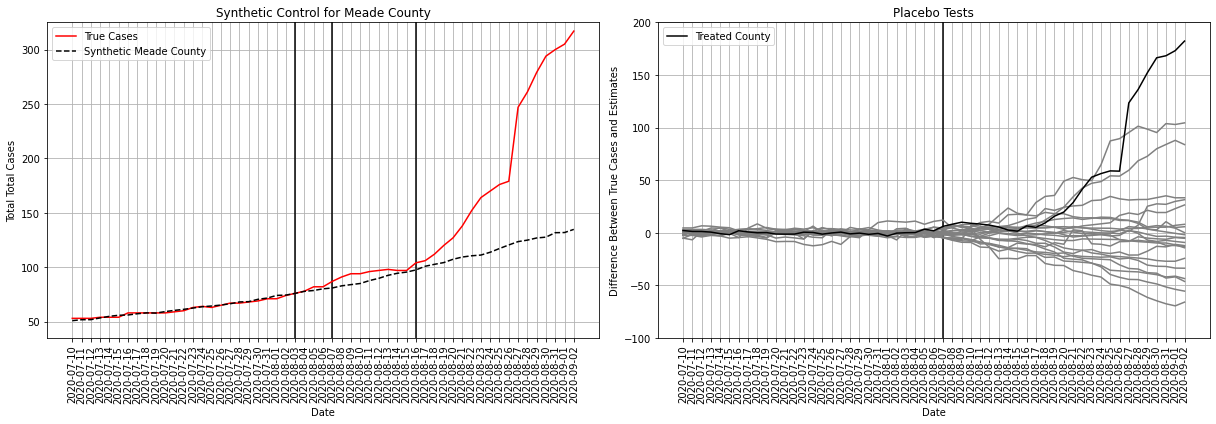

In [ ]:
plt.figure(figsize = (17, 6))
# plotting(df, synth.placebos)
plt.subplot(121) 
plt.plot(df.iloc[:, 0].values, "r", label = "True Cases") 
plt.plot(df.iloc[:, 1].values, "k--", label = "Synthetic Meade County") 
plt.vlines(x = 24, ymin = 20, ymax = 325) 
plt.vlines(x = 28, ymin = 20, ymax = 325)  
plt.vlines(x = 37, ymin = 20, ymax = 325) 
plt.xticks(range(len(df.iloc[:, 0].values)), df.index, rotation = "vertical")
plt.title("Synthetic Control for Meade County") 
plt.ylabel("Total Total Cases") 
plt.xlabel("Date")
plt.ylim((35, 325)) 
plt.legend() 
plt.grid()        

plt.subplot(122) 
for i in range(synth.placebos.shape[1]):  
    plt.plot(synth.placebos.values[:, i], "gray")
plt.plot(df.iloc[:, -1].values, "k", label = "Treated County") 
plt.xticks(range(len(df.iloc[:, 0].values)), df.index, rotation = "vertical") 
plt.title("Placebo Tests")  
plt.xlabel("Date")  
plt.ylabel("Difference Between True Cases and Estimates") 
plt.vlines(x = 28, ymin = -100, ymax = 200)  
plt.ylim((-100, 200))
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
np.mean(synth.y_pre), np.mean(np.mean(synth.X_pre, axis = 0)), df[df.index <= "2020-08-06"].iloc[:, 1].mean()   

(63.92857142857143, 60.544217687074834, 63.9298152038243)

# SYNTH FOR ONLY SD AND BORDER STATES 

In [ ]:
temp = data[data.county.str.contains("South Dakota") | data.county.str.contains("Nebraska") | data.county.str.contains("Minnesota") | data.county.str.contains("Wyoming") | data.county.str.contains("Iowa") | data.county.str.contains("Montana")]
temp.shape 

(22165, 8)

In [ ]:
dates = temp.date 
counties = temp.county.unique().tolist()   
temp_cases = temp.cases.values.reshape(len(counties), 55).T 

final_df_borders = pd.DataFrame(temp_cases, columns = counties).set_index(dates.values[: 55])   

In [ ]:
final_df_borders.shape  

(55, 403)

In [ ]:
synth = synthetic_control(final_df_borders, "Meade South Dakota")   
synth.generate_synthetic_control(k_neighbors = 21) 
df = synth.synthetic_df
synth.generate_placebos() 

WEIGHTS ALL > 0: True
SUM OF WEIGHTS = 1.0000


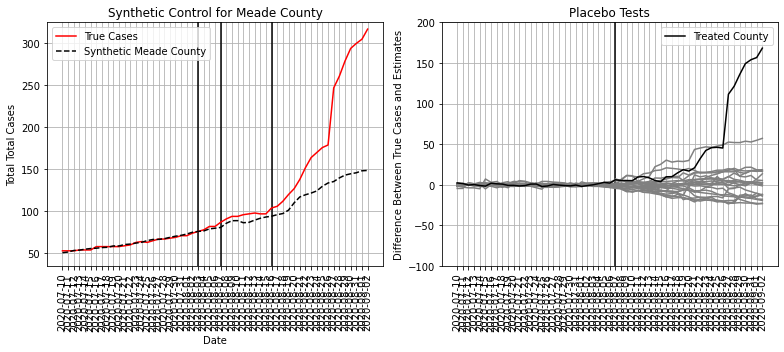

In [ ]:
plotting(df, synth.placebos)  

In [ ]:
np.mean(synth.y_pre), np.mean(np.mean(synth.X_pre, axis = 0)), df[df.index <= "2020-08-06"].iloc[:, 1].mean() 

(63.92857142857143, 64.43197278911563, 63.965172690147156)

In [ ]:
donor_fips = data[data.county.isin(temp.county.unique())].fips.unique().tolist()   

np.mean(mask_data[mask_data.fips.isin(donor_fips)].values[:, 2:][1: ], axis = 0)  

array([0.12256965174129347, 0.12557213930348263, 0.15522885572139297,
       0.2321641791044778, 0.36444527363184104, 0.9109137082417047,
       0.012577991216016032, 0.046950208643829754, 0.01028461983835279,
       0.0008908450618442127, 0.15044520429654729, 1.319866319947468],
      dtype=object)

In [ ]:
donor_ave = mask_data[mask_data.fips.isin(set(donor_fips))].iloc[:, 2: -1].mean() 
meade_vals = mask_data[mask_data.fips == 46093].values[0][2: -1]   

donor_ave

never                  0.122571
rarely                 0.125454
sometimes              0.155243
frequently             0.232119
always                 0.364596
pct_white              0.910899
pct_black              0.012596
pct_american_indian    0.046912
pct_asian              0.010285
pct_pacific_island     0.000891
pct_18_29              0.150449
dtype: float64

In [ ]:
df = pd.DataFrame({"Meade County": meade_vals, "Donor Average": donor_ave, "Synthetic": np.zeros_like(donor_ave)})    
df.index = ["Never", "Rarely", "Sometimes", "Frequently", "Always", "% White", "% Black", "% American Indian", "% Asian", "% Pacific Island", "% Pop. Age 18-19"] 
df 

,Meade County,Donor Average,Synthetic
Never,0.123,0.122571,0.0
Rarely,0.078,0.125454,0.0
Sometimes,0.161,0.155243,0.0
Frequently,0.214,0.232119,0.0
Always,0.425,0.364596,0.0
% White,0.905125,0.910899,0.0
% Black,0.0198009,0.012596,0.0
% American Indian,0.0316603,0.046912,0.0
% Asian,0.0103064,0.010285,0.0
% Pacific Island,0.00091769,0.000891,0.0


In [ ]:
df.to_latex(index = True, multirow = False, float_format="{:.3f}".format) 

'\\begin{tabular}{llrr}\n\\toprule\n{} & Meade County &  Donor Average &  Synthetic \\\\\n\\midrule\nNever             &        0.123 &          0.121 &      0.000 \\\\\nRarely            &        0.078 &          0.121 &      0.000 \\\\\nSometimes         &        0.161 &          0.151 &      0.000 \\\\\nFrequently        &        0.214 &          0.237 &      0.000 \\\\\nAlways            &        0.425 &          0.370 &      0.000 \\\\\n\\% White           &        0.905 &          0.903 &      0.000 \\\\\n\\% Black           &        0.020 &          0.014 &      0.000 \\\\\n\\% American Indian &        0.032 &          0.052 &      0.000 \\\\\n\\% Asian           &        0.010 &          0.011 &      0.000 \\\\\n\\% Pacific Island  &        0.001 &          0.001 &      0.000 \\\\\n\\% Pop. Age 18-19  &        0.152 &          0.150 &      0.000 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
temp_mask_data = mask_data[mask_data.fips.isin(donor_fips)]
temp_mask_data.head()
print(temp_mask_data.shape) 

(403, 14)


In [ ]:
temp = temp[temp.county.isin(temp_mask_data.iloc[: 201].county.unique())] 

dates = temp.date 
counties = temp.county.unique().tolist()   
temp_cases = temp.cases.values.reshape(len(counties), 55).T 

final_df_borders = pd.DataFrame(temp_cases, columns = counties).set_index(dates.values[: 55])  

In [ ]:
########## MATCHING ON DEMOGRAPHIC CHARACTERISTICS ########## 

In [ ]:
synth = synthetic_control(final_df_borders, "Meade South Dakota") 
synth.generate_synthetic_control(k_neighbors = 21) 
synth.generate_placebos() 
df = synth.synthetic_df 

WEIGHTS ALL > 0: True
SUM OF WEIGHTS = 1.0000


In [ ]:
len(synth.donor_counties)

21

In [ ]:
n = pd.DataFrame({"Donor Counties": synth.donor_counties, "Weights": synth.weights}).values 
l = pd.DataFrame({"County": n[:, 0][: 11], "Weight": n[:, 1][: 11]})
r = pd.DataFrame({"County2": n[:, 0][11: ], "Weight2": n[:, 1][11: ]}).append(pd.DataFrame({"County2": [0], "Weight2": [0]}))
r.index = list(range(0, 11))
print(pd.concat([l, r], axis = 1).to_latex(index = True, multirow = False, float_format="{:.3f}".format)) 

\begin{tabular}{lllll}
\toprule
{} &                County & Weight &             County2 & Weight2 \\
\midrule
0  &    Morrison Minnesota &  0.000 &       York Nebraska &   0.000 \\
1  &      Meeker Minnesota &  0.000 &         Monroe Iowa &   0.000 \\
2  &   Faribault Minnesota &  0.000 &        Madison Iowa &   0.322 \\
3  &   Hughes South Dakota &  0.000 &  Chippewa Minnesota &   0.186 \\
4  &          Fayette Iowa &  0.076 &         Grundy Iowa &   0.223 \\
5  &         Delaware Iowa &  0.000 &      Winnebago Iowa &   0.000 \\
6  &    Lyman South Dakota &  0.000 &     Seward Nebraska &   0.000 \\
7  &        Albany Wyoming &  0.000 &   Wabasha Minnesota &   0.000 \\
8  &  Roberts South Dakota &  0.000 &          Union Iowa &   0.167 \\
9  &     Jackson Minnesota &  0.000 &       Buchanan Iowa &   0.000 \\
10 &          Kossuth Iowa &  0.027 &                   0 &       0 \\
\bottomrule
\end{tabular}



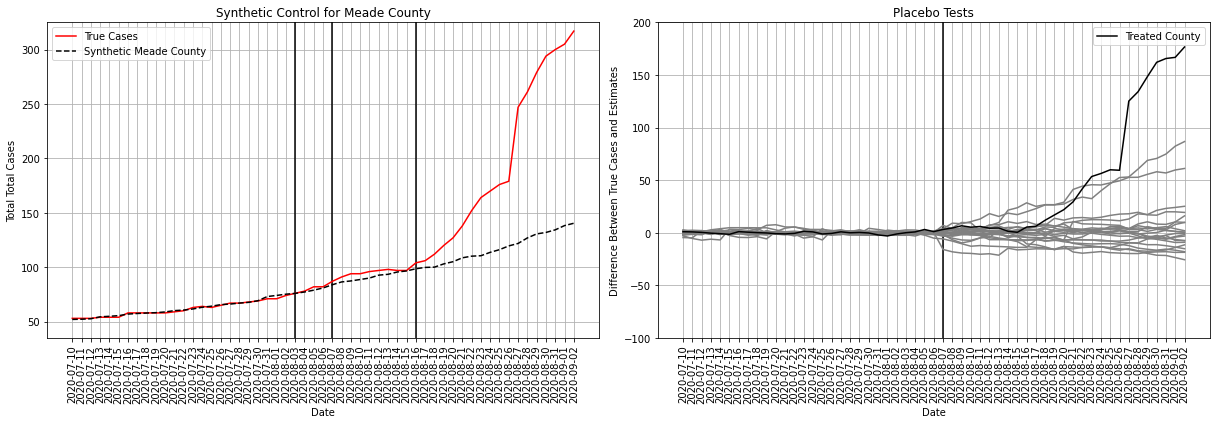

In [ ]:
plt.figure(figsize = (17, 6))
# plotting(df, synth.placebos)
plt.subplot(121) 
plt.plot(df.iloc[:, 0].values, "r", label = "True Cases") 
plt.plot(df.iloc[:, 1].values, "k--", label = "Synthetic Meade County") 
plt.vlines(x = 24, ymin = 20, ymax = 325) 
plt.vlines(x = 28, ymin = 20, ymax = 325)  
plt.vlines(x = 37, ymin = 20, ymax = 325) 
plt.xticks(range(len(df.iloc[:, 0].values)), df.index, rotation = "vertical")
plt.title("Synthetic Control for Meade County") 
plt.ylabel("Total Total Cases") 
plt.xlabel("Date")
plt.ylim((35, 325)) 
plt.legend() 
plt.grid()        
 

plt.subplot(122) 
for i in range(synth.placebos.shape[1]):  
    plt.plot(synth.placebos.values[:, i], "gray")
plt.plot(df.iloc[:, -1].values, "k", label = "Treated County") 
plt.xticks(range(len(df.iloc[:, 0].values)), df.index, rotation = "vertical") 
plt.title("Placebo Tests")   
plt.xlabel("Date")
plt.ylabel("Difference Between True Cases and Estimates") 
plt.vlines(x = 28, ymin = -100, ymax = 200)  
plt.ylim((-100, 200))
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
df

,Meade South Dakota True Cases,Meade South Dakota Synthetic,Meade South Dakota Difference
2020-07-10,53.0,52.007319,0.992681
2020-07-11,53.0,52.189511,0.810489
2020-07-12,53.0,52.632247,0.367753
2020-07-13,54.0,54.389413,-0.389413
2020-07-14,54.0,54.876406,-0.876406
2020-07-15,54.0,55.485879,-1.485879
2020-07-16,58.0,56.926704,1.073296
2020-07-17,58.0,57.453702,0.546298
2020-07-18,58.0,57.889495,0.110505
2020-07-19,58.0,58.211854,-0.211854


In [ ]:
np.mean(synth.y_pre), np.mean(np.mean(synth.X_pre, axis = 0)), df[df.index <= "2020-08-06"].iloc[:, 1].mean()   

(63.92857142857143, 64.8112244897959, 63.984963171677805)

In [ ]:
mask_data[mask_data.fips.isin(temp.fips.unique())].mean()

fips                   31555.567164
never                      0.120970
rarely                     0.121323
sometimes                  0.150786
frequently                 0.237149
always                     0.369711
pct_white                  0.902545
pct_black                  0.014137
pct_american_indian        0.052324
pct_asian                  0.010726
pct_pacific_island         0.000783
pct_18_29                  0.150294
similarity                 1.266160
dtype: float64

In [ ]:
mask_data[mask_data.fips == 46093]

,fips,county,never,rarely,sometimes,frequently,always,pct_white,pct_black,pct_american_indian,pct_asian,pct_pacific_island,pct_18_29,similarity
0,46093,Meade South Dakota,0.123,0.078,0.161,0.214,0.425,0.905125,0.019801,0.03166,0.010306,0.000918,0.152033,0.0


Wild results ^^ could be due to matching on mask wearing data -- people could have lower standards of mask wearing since SD is so socially distant already, and the counties chosen in the donor pool have low populations and less interaction, thus fewer cases, putting downward pressure on our estimated Meade County. Counties that best match pre-treatment and best match on mask wearing are not necessarily the same 

In [ ]:
pre = df[df.index <= "2020-08-07"].values[:, :2]

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
np.sqrt(mean_squared_error(pre[:, 0], pre[:, 1]))

57.40511380208922